# Trainning Pipeline

In this notebook we will create a training dataset from the feature groups:
1. Select the features we want to train our model on,
2. How the features should be preprocessed,
3. Create a Feature View.
4. Create a dataset split for training and validation data.

In [43]:
import os
import sys
from pathlib import Path
import time
from dotenv import load_dotenv
import hopsworks
from confluent_kafka import Producer
import pandas as pd
import logging


sys.path.insert(0, str(Path().resolve().parent / "src"))
from paths import *

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(module)s - %(message)s",
    level=logging.INFO
)

logger = logging.getLogger(__name__)

# load environment
load_dotenv(dotenv_path="/src/.env")


HOPSWORK_LOGIN_API_KEY = os.getenv("HOPSWORK_LOGIN_API_KEY")

In [41]:
# Login to the Hopsworks feature store
project = hopsworks.login(
    host='c.app.hopsworks.ai',                 # DNS of your Feature Store instance
    port=443,  
    project='air_quality_project', 
    engine="python",
    api_key_value=HOPSWORK_LOGIN_API_KEY
)


2025-03-10 14:43:24,837 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-10 14:43:24,860 INFO: Initializing external client
2025-03-10 14:43:24,860 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-10 14:43:27,621 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214615


In [42]:
# connect to feature store
project_name = "air_quality_project"

try:
    feature_store = project.get_feature_store(name=project_name)
    logger.info(f"✅ Successfully Connected to {feature_store.project_name}")
except Exception as err:
    logger.info(f"❌ Error accessing the Feature Store!")
    raise err

2025-03-10 14:43:31,117 INFO: ✅ Successfully Connected to air_quality_project


## Create Feature View

A feature view is a logical view over (or interface to) a set of features that may come from different feature groups. You create a feature view by joining together features from existing feature groups. 

Feature views can include:

- the label for the supervised ML problem
- transformation functions that should be applied to specified features consistently between training and serving
- the ability to create training data
- the ability to retrieve a feature vector with the most recent feature values

Let's first get a feature_view for the dataset, or create one if it does not already exist. If you are running this notebook for the first time, it will create the feature view, which contains all of the columns from the feature group.


In [5]:
# This feature view only uses on feature group, so the query is trivial

# select all features except row_id, timestamp, date, time, aqi
fg = feature_store.get_external_feature_group(name="air_quality_historical_data_2020_to_2025", version=1)
query = fg.select_except(["timestamp","date","time", "aqi"])



try:
    # access feature view if already exit
    feature_view = feature_store.get_feature_view(name="air_quality_view", version=1)
except:
    # create feature view if it doesn't exist yet
    feature_view = feature_store.create_feature_view(
        name='air_quality_view',
        description="Features from Air Quality Data",
        labels=["aqi_bucket"],
        query=query,
    )
    

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214615/fs/1202247/fv/air_quality_view/version/1


We will read our features and labels split into a train_set and a test_set. You split your data into a train_set and a test_set, because you want to train your model on only the train_set, and then evaluate its performance on data that was not seen during training, the test_set. This technique helps evaluate the ability of your model to accurately predict on data it has not seen before.

We can ask the feature_view to return a train_test_split and it returns:

- X_ is a vector of features, so **X_train** is a vector of features from the train_set.
- y_ is a scale of labels, so **y_train** is a scalar of labels from the train_set.

Note: a vector is an array of values and a scalar is a single value.

Note: that mathematical convention is that a vector is denoted by an uppercase letter (hence "X") and a scalar is denoted by a lowercase letter (hence "y").

**X_test** is the features and **y_test** is the labels from our holdout test_set. The test_set is used to evaluate model performance after the model has been trained.

## Building Machine Learning Model

In [29]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from numpy import ravel                                  # For matrices
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV      # For optimization


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (13.34s) 


In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (29049, 8)
y_train shape: (29049, 1)


In [17]:
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (7263, 8)
y_test shape: (7263, 1)


Now, we can fit a model to our features and labels from our training set (X_train and y_train).

Fitting a model to a dataset is more commonly called "training a model".

In [45]:
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=4)

In [46]:
# KNN
print('Training set score: ' + str(model.score(X_train,y_train)))
print('Test set score: ' + str(model.score(X_test,y_test)))

Training set score: 0.8799614444559193
Test set score: 0.7998072421864243


In [47]:
y_pred = model.predict(X_test)
y_pred

array(['Poor', 'Poor', 'Moderate', ..., 'Very Poor', 'Poor', 'Moderate'],
      dtype=object)

In [48]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7998072421864243


In [49]:
metrics = classification_report(y_test, y_pred,  output_dict=True)
print(metrics)

{'Fair': {'precision': 0.7623126338329764, 'recall': 0.8537170263788969, 'f1-score': 0.8054298642533937, 'support': 417.0}, 'Good': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3.0}, 'Moderate': {'precision': 0.48239771646051377, 'recall': 0.5971731448763251, 'f1-score': 0.5336842105263158, 'support': 849.0}, 'Poor': {'precision': 0.5313935681470138, 'recall': 0.5087976539589443, 'f1-score': 0.5198501872659176, 'support': 1364.0}, 'Very Poor': {'precision': 0.9578449053201082, 'recall': 0.9177105831533477, 'f1-score': 0.9373483344363556, 'support': 4630.0}, 'accuracy': 0.7998072421864243, 'macro avg': {'precision': 0.7467897647521224, 'recall': 0.7754796816735028, 'f1-score': 0.7592625192963965, 'support': 7263.0}, 'weighted avg': {'precision': 0.8109710544083651, 'recall': 0.7998072421864243, 'f1-score': 0.8042077092112826, 'support': 7263.0}}


In [50]:
results = confusion_matrix(y_test, y_pred)
print(results)

[[ 356    0   57    4    0]
 [   0    3    0    0    0]
 [  93    0  507  242    7]
 [  18    0  472  694  180]
 [   0    0   15  366 4249]]


In [51]:
X_train.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
1,1134.87,1.23,14.91,41.84,6.74,29.69,43.85,16.47
2,1842.50,3.38,21.08,2.21,10.73,64.25,92.36,30.15
3,3044.13,13.19,18.51,0.20,12.28,301.50,506.21,28.63
5,2857.21,0.06,38.73,74.39,19.07,134.57,210.41,49.14
6,5340.58,35.32,18.17,0.00,18.60,324.12,402.20,43.57


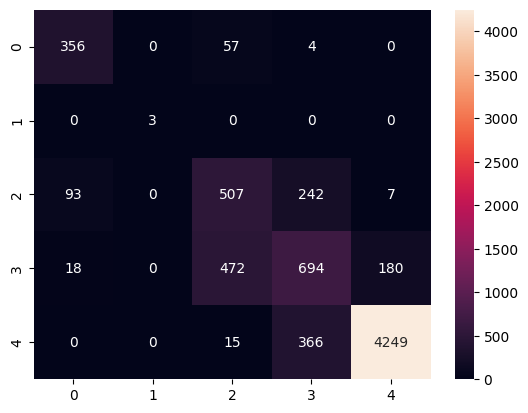

In [52]:

cm = sns.heatmap(results, annot=True, fmt=".0f")

fig = cm.get_figure()
fig.savefig("../reports/confusion_matrix.png") 
fig.show()

## Register the Model with Hopsworks Model Registry


In [66]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

#project =  hopsworks.login()
mr = project.get_model_registry()

# The 'air_quality_model' directory will be saved to the model registry
model_dir = MODELS_DIR

if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
    
joblib.dump(model, model_dir / "air_quality_model.pkl")

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

air_quality_model = mr.python.create_model(
    version=1,
    name="air_quality", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    input_example=input_example, 
    description="Air Quality Predictor")

air_quality_model.save(str(model_dir))

Uploading: 100.000%|██████████| 4348806/4348806 elapsed<00:18 remaining<00:001.12s/it]
Uploading: 100.000%|██████████| 58/58 elapsed<00:02 remaining<00:0020<00:46, 11.64s/it]
Uploading: 100.000%|██████████| 713/713 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:31<00:00,  5.30s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214615/models/air_quality/1


Model(name: 'air_quality', version: 1)